In [364]:
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix
import string
from collections import defaultdict
from tqdm import tqdm
def tokenize(document):
    return document.split()

def better_tokenize(document):
    document = (
        document.lower().translate(str.maketrans('','', string.punctuation))
        .replace("\r", " ")
        .replace("\n", " ")
        .replace("\"", "")
        .replace("\'", "")
        )
    return tokenize(document)

def create_word_counts_dict(lines, filter=0):
    word_counts = defaultdict(lambda: 0)

    for line in lines:
        tokens = better_tokenize(line)
        for token in tokens:
            word_counts[token] += 1
    return {k: v for k, v in word_counts.items() if v >= filter}

def create_term_document_matrix(file_name, include_intercept=False):
    lines = pd.read_csv(file_name)
    word_counts = create_word_counts_dict(lines["text"], filter=2)
    word_idx = {k: i for i, k in enumerate(word_counts)}
    V = len(word_counts)
    if include_intercept:
        V += 1
    D = lines.shape[0]
    X = dok_matrix((D, V), dtype=np.int64)
    for i in range(D):
        word_counts_doc = create_word_counts_dict(pd.Series(lines.iloc[i]["text"]))
        # y[i] = int(lines[i+1].strip().split(",")[-1])
        if include_intercept:
            X[i,0] = 1
        for word in word_counts_doc:
            if word in word_idx:
                j = word_idx[word]
                X[i,j] = word_counts_doc[word]
    return X, lines["sarcastic"], word_idx




X, y, word_idx = create_term_document_matrix("si630w23-hw1.train.csv", include_intercept=True)

In [365]:
class LogisticRegression():
    def __init__(self, 
                 X, 
                 y,
                 learning_rate=1e-1,
                 num_steps=100000,
                 epochs=25,
                 step_interval=50
                ):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.old_beta = np.random.rand(X.shape[1])
        self.new_beta = np.random.rand(X.shape[1])
        self.loss = []
        self.epochs = epochs
        self.step_interval=step_interval

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log_likelihood(self):
        y_hat = sigmoid(self.X @ self.new_beta.T)
        ll = np.sum(self.y * np.log(y_hat) + (1-self.y) * np.log(1-y_hat))
        return ll

    def compute_gradient(self, xi, yi):
        gradient = (yi - self.sigmoid(xi @ self.old_beta.T)) * xi
        return gradient

    def converged(self):
        if np.sum(self.old_beta) == np.sum(self.new_beta): # first iteration
            return False
        return np.allclose(self.old_beta, self.new_beta, atol=1e-1)

    def __call__(self):
        N = self.X.shape[0]
        order = np.arange(N)
        steps = 0
        epochs = 0
        while not self.converged() and epochs < self.epochs and (steps < self.num_steps):
            np.random.shuffle(order)
            for idx in tqdm(order):
                steps += 1
                xi, yi = self.X[idx], self.y[idx]
                self.new_beta = self.old_beta + (self.learning_rate * self.compute_gradient(xi, yi))
                self.old_beta = self.new_beta
                if (steps % self.step_interval == 0):
                    self.loss.append(self.log_likelihood())
            epochs += 1

    def predict(self, sentence, word_idx, include_intercept=1):
        tokens = better_tokenize(sentence)
        xi = np.zeros(X.shape[1])
        for token in tokens:
            if token in word_idx:
                xi[word_idx[token] + include_intercept] += 1
        if include_intercept:
            xi[0] = 1
        return self.sigmoid(xi @ self.new_beta.T)

In [366]:
model = LogisticRegression(X, y, num_steps=1000)
model()

100%|██████████| 3467/3467 [00:12<00:00, 285.05it/s]


Text(0.5, 1.0, 'Log Likelihood')

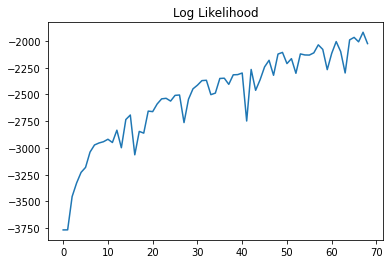

In [367]:
pd.Series(model.loss).plot().set_title("Log Likelihood")

In [368]:
model2 = LogisticRegression(X, y)
model2()

100%|██████████| 3467/3467 [00:11<00:00, 308.68it/s]


In [369]:
from sklearn.metrics import f1_score, accuracy_score

In [370]:
test = pd.read_csv("si630w23-hw1.dev.csv")
y_hats = test["text"].apply(lambda s: round(model2.predict(s, word_idx, include_intercept=1)))
f1_score(list(test["sarcastic"]), list(y_hats))

0.29007633587786263

In [371]:
accuracy_score(list(test["sarcastic"]), list(y_hats))

0.3357142857142857

In [372]:
test = pd.read_csv("si630w23-hw1.test.csv")
test["prediction"] = test["text"].apply(lambda s: round(model2.predict(s, word_idx, include_intercept=1)))
test["prediction"]

0       1
1       0
2       0
3       1
4       0
       ..
1395    1
1396    1
1397    0
1398    1
1399    1
Name: prediction, Length: 1400, dtype: int64

In [373]:
test.to_csv("lr_submission.csv", index_label="index", columns=["prediction"])

In [374]:
!head lr_submission.csv


index,prediction
0,1
1,0
2,0
3,1
4,0
5,1
6,1
7,1
8,1
